In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
train_path = './SkinCancer/train'
valid_path = './SkinCancer/validation'
test_path = './SkinCancer/test'

In [3]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Found 1860 images belonging to 2 classes.
Found 520 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
<class 'keras.preprocessing.image.DirectoryIterator'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

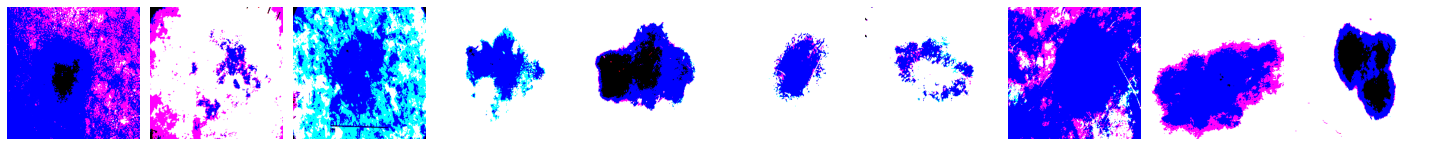

In [5]:
vgg16_train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)
vgg16_valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)
vgg16_test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32, shuffle=False)
imgs, labels = next(vgg16_train_batches)
print(type(vgg16_test_batches))

plotImages(imgs)

# print(labels)

In [7]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(x=vgg16_train_batches,
    steps_per_epoch=len(vgg16_train_batches),
    validation_data=vgg16_valid_batches,
    validation_steps=len(vgg16_valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
59/59 - 88s - loss: 0.1330 - accuracy: 0.9591 - val_loss: 0.9271 - val_accuracy: 0.8212 - 88s/epoch - 1s/step
Epoch 2/10
59/59 - 86s - loss: 0.0712 - accuracy: 0.9742 - val_loss: 0.9904 - val_accuracy: 0.8250 - 86s/epoch - 1s/step
Epoch 3/10
59/59 - 90s - loss: 0.0308 - accuracy: 0.9882 - val_loss: 0.9633 - val_accuracy: 0.8212 - 90s/epoch - 2s/step
Epoch 4/10
59/59 - 89s - loss: 0.0341 - accuracy: 0.9871 - val_loss: 1.0090 - val_accuracy: 0.8077 - 89s/epoch - 2s/step
Epoch 5/10
59/59 - 92s - loss: 0.0387 - accuracy: 0.9866 - val_loss: 0.9853 - val_accuracy: 0.8135 - 92s/epoch - 2s/step
Epoch 6/10
59/59 - 88s - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.9337 - val_accuracy: 0.8019 - 88s/epoch - 1s/step
Epoch 7/10
59/59 - 84s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.9411 - val_accuracy: 0.8058 - 84s/epoch - 1s/step
Epoch 8/10
59/59 - 90s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.0062 - val_accuracy: 0.7885 - 90s/epoch - 2s/step
Epoch 9/10
59/59 - 88s - loss: 0

Confusion matrix, without normalization
[[297  63]
 [ 58 242]]


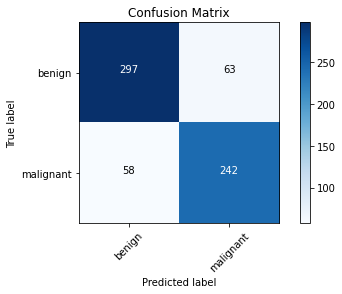

In [12]:
vgg16_predictions = model.predict(x=vgg16_test_batches, steps=len(vgg16_test_batches), verbose=0)
np.round(vgg16_predictions)
vgg16_cm = confusion_matrix(y_true=vgg16_test_batches.classes, y_pred=np.argmax(vgg16_predictions, axis=-1))
cm_plot_labels = ['benign','malignant']
plot_confusion_matrix(cm=vgg16_cm, classes=cm_plot_labels, title='Confusion Matrix')

In [34]:
vgg16_model_json = model.to_json()
with open("./SkinCancer_v2_Models/vgg16_model/vgg16_model.json", "w") as json_file:
    json_file.write(vgg16_model_json)
model.save("./SkinCancer_v2_Models/vgg16_model/vgg16_model.h5")
print("Saved model to disk")
model.save_weights("./SkinCancer_v2_Models/vgg16_model/vgg16_model_Weights.h5")

Saved model to disk


In [66]:
vgg16_results = model.evaluate(vgg16_test_batches,batch_size=32)
print("test_loss, test accuracy",vgg16_results)

21/21 [==============================] - 16s 771ms/step - loss: 0.9464 - accuracy: 0.8167
test_loss, test accuracy [0.9463834762573242, 0.8166666626930237]


In [67]:
pred_class = np.argmax(vgg16_predictions, axis=1)

true_classes = vgg16_test_batches.classes
class_labels = list(vgg16_test_batches.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.82      0.84      0.83       355
   malignant       0.81      0.79      0.80       305

    accuracy                           0.82       660
   macro avg       0.82      0.82      0.82       660
weighted avg       0.82      0.82      0.82       660



21/21 [==============================] - 13s 608ms/step


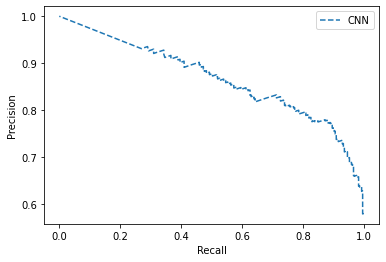

In [68]:
lr_probs = model.predict(vgg16_test_batches)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

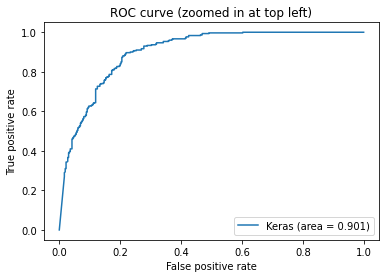

In [69]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [39]:
# history_dict = model.history
# # print(history_dict.keys())

# acc = model.history['acc']
# val_acc = model.history['val_acc']

# loss = model.history['loss']
# val_loss = model.history['val_loss']

# epochs_range = range(10)
# plt.figure(figsize=(8, 8))
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='best')
# plt.title('Training and Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.show()

Resnet V2 Preprocessing

Found 1860 images belonging to 2 classes.
Found 520 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

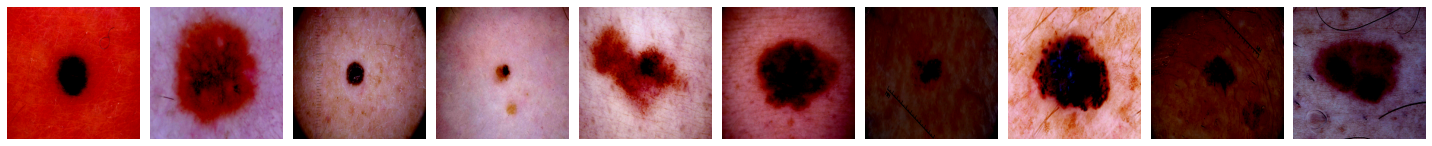

In [13]:
resnet_v2_train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)
resnet_v2_valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)
resnet_v2_test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32, shuffle=False)
imgs, labels = next(resnet_v2_train_batches)
plotImages(imgs)
# print(labels)

In [14]:
resnet_v2_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [15]:
resnet_v2_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
resnet_v2_model.fit(x=resnet_v2_train_batches,
    steps_per_epoch=len(resnet_v2_train_batches),
    validation_data=resnet_v2_valid_batches,
    validation_steps=len(resnet_v2_valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
59/59 - 87s - loss: 0.5790 - accuracy: 0.6919 - val_loss: 0.3561 - val_accuracy: 0.8904 - 87s/epoch - 1s/step
Epoch 2/10
59/59 - 91s - loss: 0.4583 - accuracy: 0.7656 - val_loss: 0.3532 - val_accuracy: 0.8635 - 91s/epoch - 2s/step
Epoch 3/10
59/59 - 92s - loss: 0.4249 - accuracy: 0.7952 - val_loss: 0.3294 - val_accuracy: 0.8615 - 92s/epoch - 2s/step
Epoch 4/10
59/59 - 90s - loss: 0.3893 - accuracy: 0.8247 - val_loss: 0.3681 - val_accuracy: 0.8365 - 90s/epoch - 2s/step
Epoch 5/10
59/59 - 90s - loss: 0.3687 - accuracy: 0.8242 - val_loss: 0.3521 - val_accuracy: 0.8500 - 90s/epoch - 2s/step
Epoch 6/10
59/59 - 89s - loss: 0.3599 - accuracy: 0.8274 - val_loss: 0.3298 - val_accuracy: 0.8635 - 89s/epoch - 2s/step
Epoch 7/10
59/59 - 88s - loss: 0.3224 - accuracy: 0.8478 - val_loss: 0.3471 - val_accuracy: 0.8500 - 88s/epoch - 1s/step
Epoch 8/10
59/59 - 85s - loss: 0.3086 - accuracy: 0.8538 - val_loss: 0.3543 - val_accuracy: 0.8500 - 85s/epoch - 1s/step
Epoch 9/10
59/59 - 88s - loss: 0

Confusion matrix, without normalization
[[307  53]
 [ 66 234]]


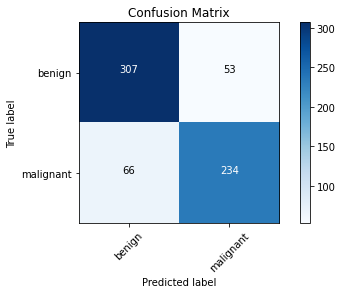

In [17]:
resnet_v2_predictions = resnet_v2_model.predict(x=resnet_v2_test_batches, steps=len(resnet_v2_test_batches), verbose=0)
np.round(resnet_v2_predictions)
resnet_v2_cm = confusion_matrix(y_true=resnet_v2_test_batches.classes, y_pred=np.argmax(resnet_v2_predictions, axis=-1))
plot_confusion_matrix(cm=resnet_v2_cm, classes=cm_plot_labels, title='Confusion Matrix')

In [40]:
resnet_v2_model_json = resnet_v2_model.to_json()
with open("./SkinCancer_v2_Models/resnet_v2_model/resnet_v2_model.json", "w") as json_file:
    json_file.write(resnet_v2_model_json)
model.save("./SkinCancer_v2_Models/resnet_v2_model/resnet_v2_model.h5")
print("Saved model to disk")
resnet_v2_model.save_weights("./SkinCancer_v2_Models/resnet_v2_model/resnet_v2_model_Weights.h5")

Saved model to disk


In [62]:
resnet_v2_results = resnet_v2_model.evaluate(resnet_v2_test_batches,batch_size=32)
print("test_loss, test accuracy",resnet_v2_results)

21/21 [==============================] - 12s 579ms/step - loss: 0.3766 - accuracy: 0.8197
test_loss, test accuracy [0.37661007046699524, 0.8196969628334045]


In [63]:
pred_class = np.argmax(resnet_v2_predictions, axis=1)

true_classes = resnet_v2_test_batches.classes
class_labels = list(resnet_v2_test_batches.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.85      0.82      0.84       373
   malignant       0.78      0.82      0.80       287

    accuracy                           0.82       660
   macro avg       0.82      0.82      0.82       660
weighted avg       0.82      0.82      0.82       660



21/21 [==============================] - 16s 741ms/step


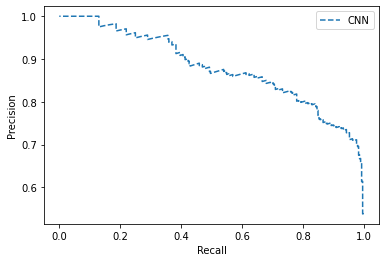

In [64]:
lr_probs = resnet_v2_model.predict(resnet_v2_test_batches)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

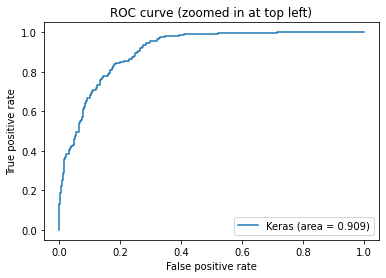

In [65]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

VGG19 Preprocessing

Found 1860 images belonging to 2 classes.
Found 520 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

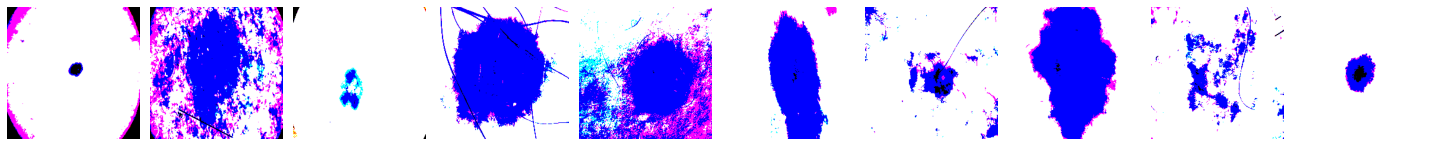

In [18]:
vgg19_train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)
vgg19_valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)
vgg19_test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32, shuffle=False)
imgs, labels = next(vgg19_train_batches)
plotImages(imgs)
# print(labels)

In [19]:
vgg19_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [20]:
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
vgg19_model.fit(x=vgg19_train_batches,
    steps_per_epoch=len(vgg19_train_batches),
    validation_data=vgg19_valid_batches,
    validation_steps=len(vgg19_valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
59/59 - 108s - loss: 8.1175 - accuracy: 0.6817 - val_loss: 1.4177 - val_accuracy: 0.7192 - 108s/epoch - 2s/step
Epoch 2/10
59/59 - 105s - loss: 1.3848 - accuracy: 0.7699 - val_loss: 0.8136 - val_accuracy: 0.8596 - 105s/epoch - 2s/step
Epoch 3/10
59/59 - 104s - loss: 1.5181 - accuracy: 0.8005 - val_loss: 1.0300 - val_accuracy: 0.7962 - 104s/epoch - 2s/step
Epoch 4/10
59/59 - 103s - loss: 0.5023 - accuracy: 0.8726 - val_loss: 0.8402 - val_accuracy: 0.8038 - 103s/epoch - 2s/step
Epoch 5/10
59/59 - 101s - loss: 0.3967 - accuracy: 0.8887 - val_loss: 0.8277 - val_accuracy: 0.8365 - 101s/epoch - 2s/step
Epoch 6/10
59/59 - 103s - loss: 0.1994 - accuracy: 0.9247 - val_loss: 1.1318 - val_accuracy: 0.8096 - 103s/epoch - 2s/step
Epoch 7/10
59/59 - 103s - loss: 0.2709 - accuracy: 0.9156 - val_loss: 1.0343 - val_accuracy: 0.7500 - 103s/epoch - 2s/step
Epoch 8/10
59/59 - 104s - loss: 0.0704 - accuracy: 0.9720 - val_loss: 0.8300 - val_accuracy: 0.8269 - 104s/epoch - 2s/step
Epoch 9/10
59/59

Confusion matrix, without normalization
[[263  97]
 [ 26 274]]


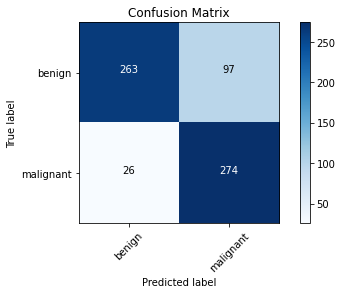

In [22]:
vgg19_predictions = vgg19_model.predict(x=vgg19_test_batches, steps=len(vgg19_test_batches), verbose=0)
np.round(vgg19_predictions)
vgg19_cm = confusion_matrix(y_true=vgg19_test_batches.classes, y_pred=np.argmax(vgg19_predictions, axis=-1))
plot_confusion_matrix(cm=vgg19_cm, classes=cm_plot_labels, title='Confusion Matrix')

In [41]:
vgg19_model_json = vgg19_model.to_json()
with open("./SkinCancer_v2_Models/vgg19_model/vgg19_model.json", "w") as json_file:
    json_file.write(vgg19_model_json)
model.save("./SkinCancer_v2_Models/vgg19_model/vgg19_model.h5")
print("Saved model to disk")
vgg19_model.save_weights("./SkinCancer_v2_Models/vgg19_model/vgg19_model_Weights.h5")

Saved model to disk


In [58]:
vgg19_results = vgg19_model.evaluate(vgg19_test_batches,batch_size=32)
print("test_loss, test accuracy",vgg19_results)

21/21 [==============================] - 16s 765ms/step - loss: 0.8391 - accuracy: 0.8136
test_loss, test accuracy [0.8390546441078186, 0.8136363625526428]


In [59]:
pred_class = np.argmax(vgg19_predictions, axis=1)

true_classes = vgg19_test_batches.classes
class_labels = list(vgg19_test_batches.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.73      0.91      0.81       289
   malignant       0.91      0.74      0.82       371

    accuracy                           0.81       660
   macro avg       0.82      0.82      0.81       660
weighted avg       0.83      0.81      0.81       660



21/21 [==============================] - 11s 523ms/step


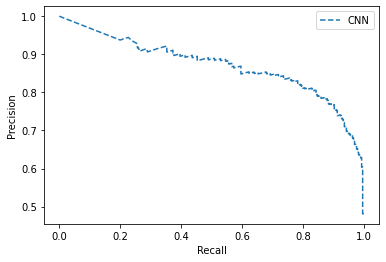

In [60]:
lr_probs = vgg19_model.predict(vgg19_test_batches)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

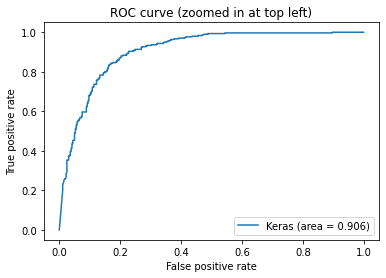

In [61]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

Mobilenet V2 Preprocessing

Found 1860 images belonging to 2 classes.
Found 520 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

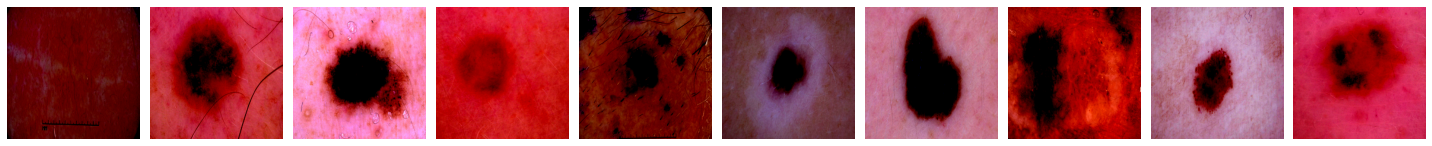

In [23]:
mobilenet_v2_train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)
mobilenet_v2_valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)
mobilenet_v2_test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32, shuffle=False)
imgs, labels = next(mobilenet_v2_train_batches)
plotImages(imgs)
# print(labels)

In [24]:
mobilenet_v2_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [25]:
mobilenet_v2_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
mobilenet_v2_model.fit(x=mobilenet_v2_train_batches,
    steps_per_epoch=len(mobilenet_v2_train_batches),
    validation_data=mobilenet_v2_valid_batches,
    validation_steps=len(mobilenet_v2_valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
59/59 - 83s - loss: 0.5963 - accuracy: 0.6790 - val_loss: 0.4748 - val_accuracy: 0.8192 - 83s/epoch - 1s/step
Epoch 2/10
59/59 - 92s - loss: 0.4941 - accuracy: 0.7608 - val_loss: 0.4285 - val_accuracy: 0.8327 - 92s/epoch - 2s/step
Epoch 3/10
59/59 - 91s - loss: 0.4542 - accuracy: 0.7823 - val_loss: 0.3694 - val_accuracy: 0.8365 - 91s/epoch - 2s/step
Epoch 4/10
59/59 - 89s - loss: 0.4012 - accuracy: 0.8151 - val_loss: 0.3401 - val_accuracy: 0.8558 - 89s/epoch - 2s/step
Epoch 5/10
59/59 - 89s - loss: 0.3780 - accuracy: 0.8247 - val_loss: 0.3557 - val_accuracy: 0.8500 - 89s/epoch - 2s/step
Epoch 6/10
59/59 - 94s - loss: 0.3545 - accuracy: 0.8349 - val_loss: 0.3308 - val_accuracy: 0.8500 - 94s/epoch - 2s/step
Epoch 7/10
59/59 - 85s - loss: 0.3380 - accuracy: 0.8473 - val_loss: 0.3390 - val_accuracy: 0.8577 - 85s/epoch - 1s/step
Epoch 8/10
59/59 - 89s - loss: 0.3460 - accuracy: 0.8349 - val_loss: 0.3304 - val_accuracy: 0.8385 - 89s/epoch - 2s/step
Epoch 9/10
59/59 - 90s - loss: 0

Confusion matrix, without normalization
[[256 104]
 [ 15 285]]


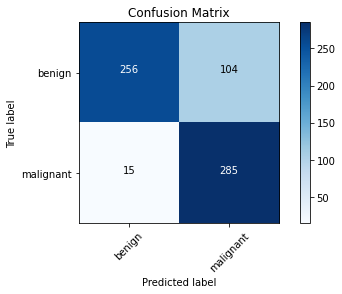

In [27]:
mobilenet_v2_predictions = mobilenet_v2_model.predict(x=mobilenet_v2_test_batches, steps=len(mobilenet_v2_test_batches), verbose=0)
np.round(mobilenet_v2_predictions)
mobilenet_v2_cm = confusion_matrix(y_true=mobilenet_v2_test_batches.classes, y_pred=np.argmax(mobilenet_v2_predictions, axis=-1))
plot_confusion_matrix(cm=mobilenet_v2_cm, classes=cm_plot_labels, title='Confusion Matrix')

In [42]:
mobilenet_v2_model_json = mobilenet_v2_model.to_json()
with open("./SkinCancer_v2_Models/mobilenet_v2_model/mobilenet_v2_model.json", "w") as json_file:
    json_file.write(mobilenet_v2_model_json)
model.save("./SkinCancer_v2_Models/mobilenet_v2_model/mobilenet_v2_model.h5")
print("Saved model to disk")
mobilenet_v2_model.save_weights("./SkinCancer_v2_Models/mobilenet_v2_model/mobilenet_v2_model_Weights.h5")

Saved model to disk


In [54]:
mobilenet_v2_results = mobilenet_v2_model.evaluate(mobilenet_v2_test_batches,batch_size=32)
print("test_loss, test accuracy",mobilenet_v2_results)

21/21 [==============================] - 18s 842ms/step - loss: 0.3915 - accuracy: 0.8197
test_loss, test accuracy [0.39150843024253845, 0.8196969628334045]


In [55]:
pred_class = np.argmax(mobilenet_v2_predictions, axis=1)

true_classes = mobilenet_v2_test_batches.classes
class_labels = list(mobilenet_v2_test_batches.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.71      0.94      0.81       271
   malignant       0.95      0.73      0.83       389

    accuracy                           0.82       660
   macro avg       0.83      0.84      0.82       660
weighted avg       0.85      0.82      0.82       660



21/21 [==============================] - 11s 524ms/step


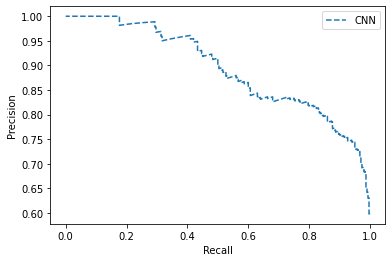

In [56]:
lr_probs = mobilenet_v2_model.predict(mobilenet_v2_test_batches)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

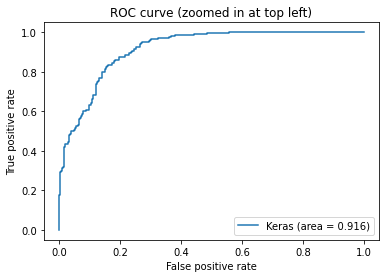

In [57]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

Mobilenet Preprocessing

Found 1860 images belonging to 2 classes.
Found 520 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

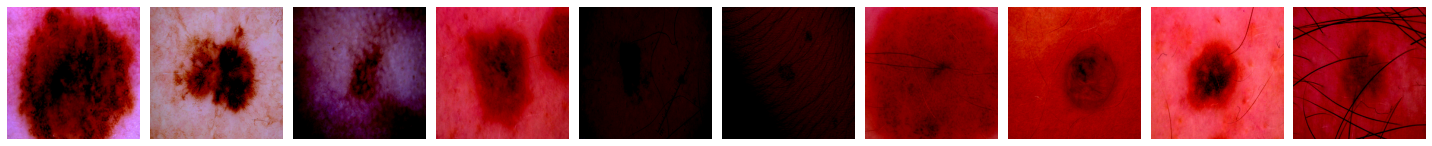

In [28]:
mobilenet_train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)
mobilenet_valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)
mobilenet_test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['benign', 'malignant'], batch_size=32, shuffle=False)
imgs, labels = next(mobilenet_train_batches)
plotImages(imgs)
# print(labels)

In [29]:
mobilenet_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [30]:
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
mobilenet_model.fit(x=mobilenet_train_batches,
    steps_per_epoch=len(mobilenet_train_batches),
    validation_data=mobilenet_valid_batches,
    validation_steps=len(mobilenet_valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
59/59 - 90s - loss: 0.5367 - accuracy: 0.7161 - val_loss: 0.3567 - val_accuracy: 0.8827 - 90s/epoch - 2s/step
Epoch 2/10
59/59 - 89s - loss: 0.4485 - accuracy: 0.7919 - val_loss: 0.3594 - val_accuracy: 0.8365 - 89s/epoch - 2s/step
Epoch 3/10
59/59 - 86s - loss: 0.4123 - accuracy: 0.8124 - val_loss: 0.3114 - val_accuracy: 0.8712 - 86s/epoch - 1s/step
Epoch 4/10
59/59 - 90s - loss: 0.3845 - accuracy: 0.8274 - val_loss: 0.3331 - val_accuracy: 0.8635 - 90s/epoch - 2s/step
Epoch 5/10
59/59 - 90s - loss: 0.3613 - accuracy: 0.8333 - val_loss: 0.3186 - val_accuracy: 0.8615 - 90s/epoch - 2s/step
Epoch 6/10
59/59 - 88s - loss: 0.3468 - accuracy: 0.8387 - val_loss: 0.4008 - val_accuracy: 0.8154 - 88s/epoch - 1s/step
Epoch 7/10
59/59 - 85s - loss: 0.3231 - accuracy: 0.8532 - val_loss: 0.3671 - val_accuracy: 0.8288 - 85s/epoch - 1s/step
Epoch 8/10
59/59 - 89s - loss: 0.3107 - accuracy: 0.8586 - val_loss: 0.3868 - val_accuracy: 0.8231 - 89s/epoch - 2s/step
Epoch 9/10
59/59 - 90s - loss: 0

Confusion matrix, without normalization
[[249 111]
 [ 15 285]]


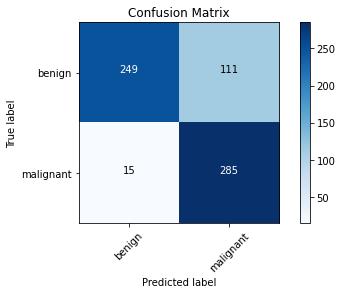

In [32]:
mobilenet_predictions = mobilenet_model.predict(x=mobilenet_test_batches, steps=len(mobilenet_test_batches), verbose=0)
np.round(mobilenet_predictions)
mobilenet_cm = confusion_matrix(y_true=mobilenet_test_batches.classes, y_pred=np.argmax(mobilenet_predictions, axis=-1))
plot_confusion_matrix(cm=mobilenet_cm, classes=cm_plot_labels, title='Confusion Matrix')

In [46]:
mobilenet_model_json = mobilenet_model.to_json()
with open("./SkinCancer_v2_Models/mobilenet_model/mobilenet_model.json", "w") as json_file:
    json_file.write(mobilenet_model_json)
model.save("./SkinCancer_v2_Models/mobilenet_model/mobilenet_model.h5")
print("Saved model to disk")
mobilenet_model.save_weights("./SkinCancer_v2_Models/mobilenet_model/mobilenet_model_Weights.h5")

Saved model to disk


In [47]:
mobilenet_results = mobilenet_model.evaluate(mobilenet_test_batches,batch_size=32)
print("test_loss, test accuracy",mobilenet_results)

21/21 [==============================] - 11s 511ms/step - loss: 0.4017 - accuracy: 0.8091
test_loss, test accuracy [0.40172743797302246, 0.8090909123420715]


In [49]:
pred_class = np.argmax(mobilenet_predictions, axis=1)

true_classes = mobilenet_test_batches.classes
class_labels = list(mobilenet_test_batches.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.69      0.94      0.80       264
   malignant       0.95      0.72      0.82       396

    accuracy                           0.81       660
   macro avg       0.82      0.83      0.81       660
weighted avg       0.85      0.81      0.81       660



21/21 [==============================] - 12s 572ms/step


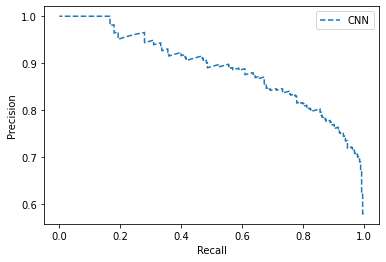

In [51]:
lr_probs = mobilenet_model.predict(mobilenet_test_batches)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

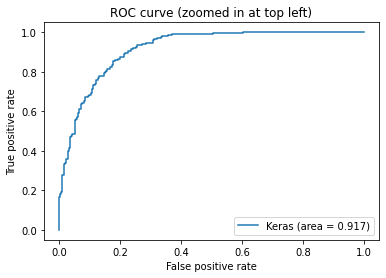

In [53]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()